In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mlccd_models
import os
import mlccd_diffusion
import pandas as pd

# deactivate GPU on ragnarok
# tf.config.set_visible_devices([], "GPU")

2024-10-30 15:24:30.077184: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 15:24:30.310304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 15:24:30.379971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 15:24:30.402065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 15:24:30.574215: I tensorflow/core/platform/cpu_feature_guar

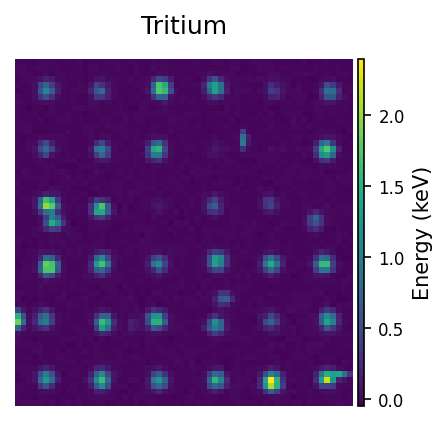

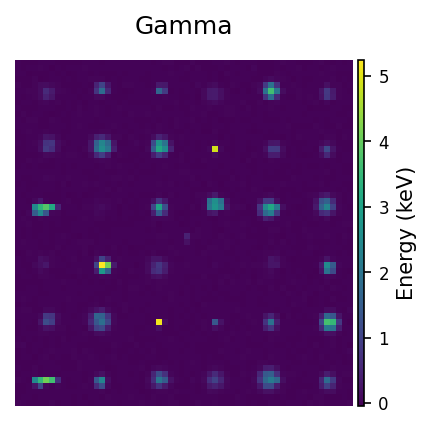

In [2]:
data_fermilab = mlccd_models.CCDData(
    os.path.expanduser('/home/emil/data/CCD_data/fermilab_clustered/fermilab_upnoised_quadrant_0_and_3_baseline_cut_unbalanced.pkl'),
    image_unit="adc"
)
data_fermilab.plot(only_one_label=1, num_plots=36, title="Tritium")
data_fermilab.plot(only_one_label=0, num_plots=36, title="Gamma")

# Clip the data between thresholds and normalize to 0-1
data_fermilab.normalize(threshold_low=0, threshold_high=20)

# Divide the data into training, test, and validation sets
data_fermilab.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

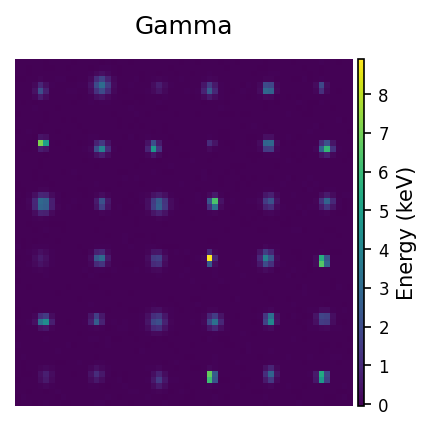

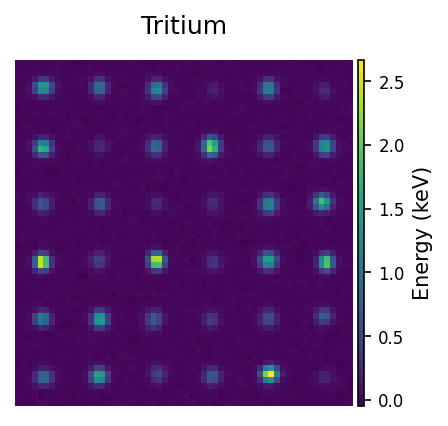

In [3]:
# Load the training and test data
data_tritium = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_H3_5000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_H3_5000000.h5"),
    image_unit="keV"
)
data_gamma = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_gamma_20000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/gamma_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_gamma_20000000.h5"),
    image_unit="keV"
)
data_gamma.plot(title="Gamma", num_plots=36)
data_tritium.plot(title="Tritium", num_plots=36)

In [4]:
# Combine the two datasets
ccd_data = 0.8 * data_gamma + 1 * data_tritium
# Clip the data between thresholds and normalize to 0-1
ccd_data.normalize(threshold_low=0, threshold_high=20)
# ccd_data = ccd_data.reduced(num_events=200000)
# Divide the data into training, test, and validation sets
ccd_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

In [5]:
model_sim = tf.keras.models.load_model("cnn_sim_100.keras")
model_sim_even = tf.keras.models.load_model("cnn_sim_even_100.keras")
model_fermilab = tf.keras.models.load_model("cnn_fermilab_400.keras")
model_fermilab = tf.keras.models.load_model("cnn_fermilab.keras")
model_sim_fine_tuned = tf.keras.models.load_model("cnn_sim_fine_tuned.keras")
model_sim_evenfine_tuned = tf.keras.models.load_model("cnn_sim_even_fine_tuned.keras")

I0000 00:00:1730327077.433813   89575 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730327077.610933   89575 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730327077.611045   89575 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730327077.617239   89575 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730327077.617316   89575 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

126/226 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


Text(0.5, 1.0, 'CNN performance on measured data')

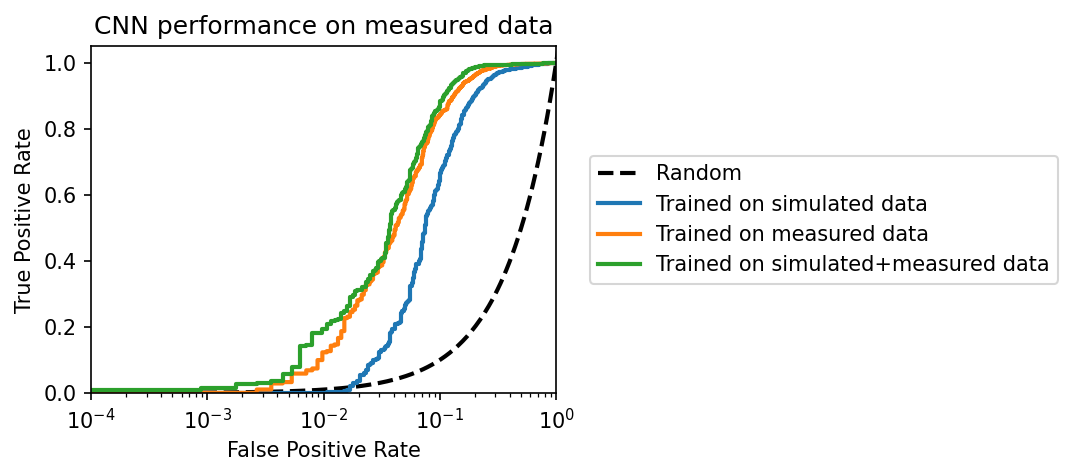

In [13]:
# y_pred_fermi_sim_model = model_sim.predict(data_fermilab.x_test)
# fig, ax = mlccd_models.plot_roc_curve(data_fermilab.y_test, y_pred_fermi_sim_model, log_scale=True, label="CNN trained on simulated data", ax=None)
y_pred_fermi_even_model = model_sim_even.predict(data_fermilab.x_test)
fig, ax = mlccd_models.plot_roc_curve(data_fermilab.y_test, y_pred_fermi_even_model, log_scale=True, label="Trained on simulated data", ax=None)
y_pred_fermi_fermilab_model = model_fermilab.predict(data_fermilab.x_test)
mlccd_models.plot_roc_curve(data_fermilab.y_test, y_pred_fermi_fermilab_model, log_scale=True, label="Trained on measured data", ax=ax)
# y_pred_fermi_finetune = model_sim_fine_tuned.predict(data_fermilab.x_test)
# mlccd_models.plot_roc_curve(data_fermilab.y_test, y_pred_fermi_finetune, log_scale=True, label="Tained on simulated+measured data", ax=ax)
y_pred_fermi_even_finetune = model_sim_evenfine_tuned.predict(data_fermilab.x_test)
mlccd_models.plot_roc_curve(data_fermilab.y_test, y_pred_fermi_even_finetune, log_scale=True, label="Trained on simulated+measured data", ax=ax)
ax.set_title("CNN performance on measured data")


  276/11805 ━━━━━━━━━━━━━━━━━━━━ 6s 546us/step

11805/11805 ━━━━━━━━━━━━━━━━━━━━ 7s 599us/step
11805/11805 ━━━━━━━━━━━━━━━━━━━━ 7s 634us/step
11805/11805 ━━━━━━━━━━━━━━━━━━━━ 7s 630us/step


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

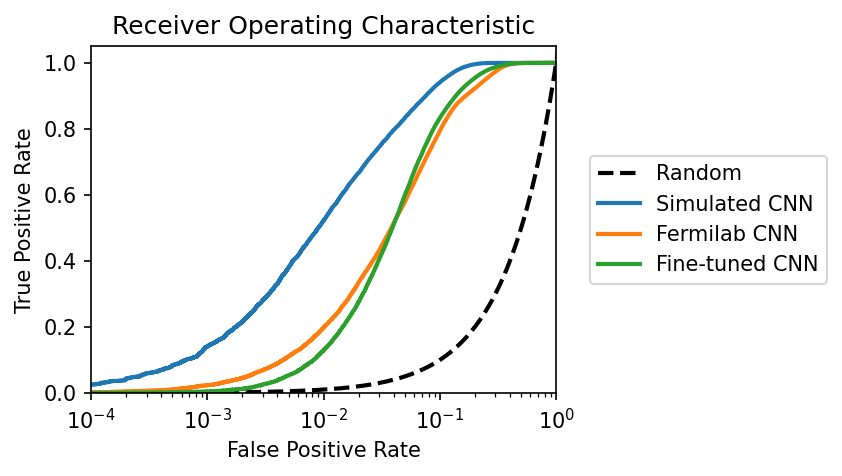

In [7]:
y_pred_sim = model_sim.predict(ccd_data.x_test)
y_pred_fermilab = model_fermilab.predict(ccd_data.x_test)
y_pred_sim_fine_tuned = model_sim_fine_tuned.predict(ccd_data.x_test)
fig, ax = mlccd_models.plot_roc_curve(ccd_data.y_test, y_pred_sim, log_scale=True, label="Simulated CNN")
mlccd_models.plot_roc_curve(ccd_data.y_test, y_pred_fermilab, log_scale=True, label="Fermilab CNN", ax=ax)
mlccd_models.plot_roc_curve(ccd_data.y_test, y_pred_sim_fine_tuned, log_scale=True, label="Fine-tuned CNN", ax=ax)



NameError: name 'y_pred_fermi_sim_model' is not defined

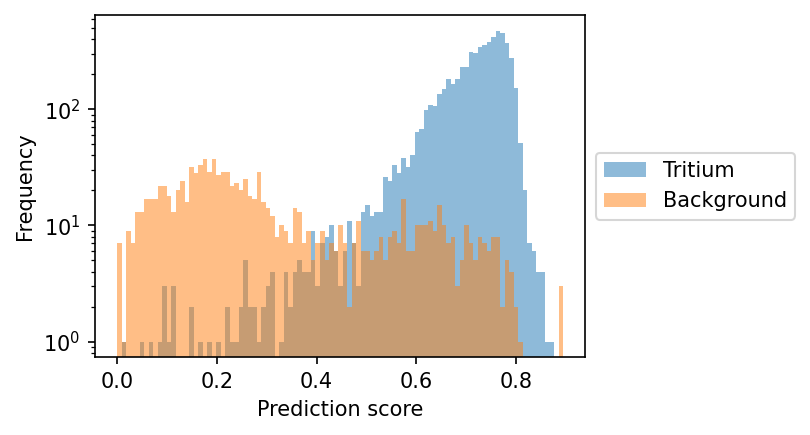

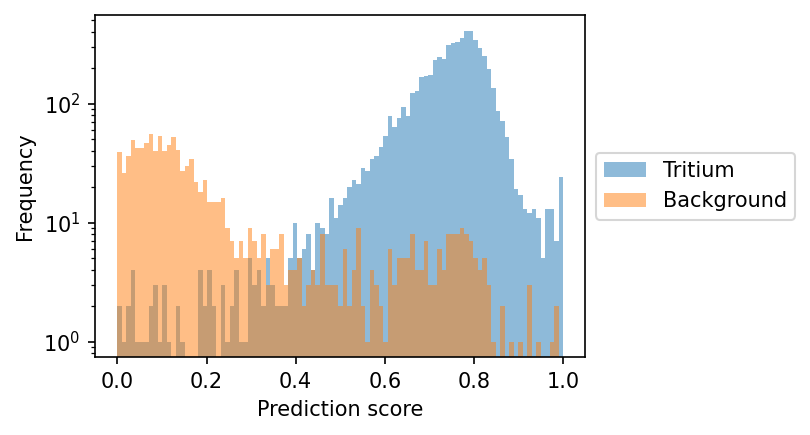

In [8]:
fig, ax = mlccd_models.plot_scores(data_fermilab.y_test, y_pred_fermi_fermilab_model)
fig, ax = mlccd_models.plot_scores(data_fermilab.y_test, y_pred_fermi_finetune)
fig, ax  = mlccd_models.plot_scores(data_fermilab.y_test, y_pred_fermi_sim_model)
fig, ax  = mlccd_models.plot_scores(ccd_data.y_test, y_pred_sim)


### Fine-tune sim model with meas data

In [8]:
gamma = 2
loss_function = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=gamma, from_logits=False, apply_class_balancing=True
)
# loss_function = 'binary_crossentropy'
config = {
    "model_name": f'cnn_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}',
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": ccd_data.file_path,
    "epochs": 400,
    "batch_size": 256 * 4,
    "loss_function": loss_function,
    "threshold_high": ccd_data.threshold_high,
    "threshold_low": ccd_data.threshold_low,
    "data_filename": ccd_data.file_path,
}

In [9]:
model_sim_fine_tuned = tf.keras.models.load_model("cnn_sim_even_100.keras")
mlccd_models.train(model=model_sim_fine_tuned, config=config, ccd_data=data_fermilab, offline=True)

Epoch 1/400


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0792 - val_loss: 0.0355
Epoch 2/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 - val_loss: 0.0292
Epoch 3/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - val_loss: 0.0269
Epoch 4/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0268 - val_loss: 0.0255
Epoch 5/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 - val_loss: 0.0251
Epoch 6/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0251 - val_loss: 0.0244
Epoch 7/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - val_loss: 0.0243
Epoch 8/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0238 - val_loss: 0.0239
Epoch 9/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - val_loss: 0.0237
Epoch 10/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 11/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 12/400
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - val_l

In [10]:
model_sim_fine_tuned.save("cnn_sim_even_fine_tuned.keras")
